In [85]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import DeepMice.data_loader as dl
from DeepMice.nets import MLPNet
from DeepMice.train import train_test_classification
from DeepMice.utils import shuffle_and_split_data

In [86]:
# read neural data and labels
data = dl.load_example_data(path='one_example_session.npy', print_keys=True)

stimulus_details = data['stim_details_pandas']
nr_frames_after=5 
neuron_time = data['neuron_time']
activity = data['neuron_activity']
[trial_matrix_3d, image_index, is_change] = dl.get_trial_matrix_3d(activity, neuron_time, stimulus_details, nr_frames_after)

Keys in the data dictionary:
 dict_keys(['neuron_fluoresence', 'neuron_activity', 'neuron_time', 'running_pandas', 'stim_details_pandas', 'pupil_area_pandas', 'licks_pandas', 'reward_pandas'])


In [87]:
# reshape (trial x feature) and preprocess
nr_trials = trial_matrix_3d.shape[0]
trial_matrix = trial_matrix_3d.reshape(nr_trials,-1) 
# normalize unit activations across trials
mean = np.mean(trial_matrix, 0)
std = np.std(trial_matrix, 0)
trial_matrix = (trial_matrix - mean)/std

# split data
seed = 2021
ratio = 0.2
X_test, y_test, X_train, y_train = shuffle_and_split_data(trial_matrix, image_index, ratio, seed)

In [88]:
# train_loader and test_loader
batch_size = 128
g_seed = torch.Generator()
g_seed.manual_seed(seed)
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_data,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=1,
                            worker_init_fn=seed_worker,
                            generator=g_seed)

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_data,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=1,
                             worker_init_fn=seed_worker,
                             generator=g_seed)

In [89]:
# set MLP achitecture
input_feature_num = X_train.shape[1]
hidden_unit_nums = [100, 100]
output_feature_num = 9
cat_net = MLPNet('ReLU()', input_feature_num, hidden_unit_nums, output_feature_num).to(device)

In [90]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'



Accuracy on the 3841 training samples: 100.00
Accuracy on the 960 testing samples: 87.92



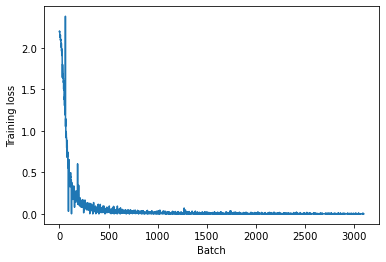

(100.0, 87.91666666666667)

In [91]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cat_net.parameters(), lr=3e-4)
train_test_classification(cat_net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=100, verbose=True,
                              training_plot=True, device=device)